# Exploratory data analysis of European football	competitions, season 2014/2015
The PATH variable in the notebook should be changed to the path where the database was downloaded

In [1]:
%matplotlib inline

# The PATH variable in the notebook should be changed to the path where the database was downloaded

## 1. Abstract
The current work analysis performs exploratary data analysis on European Soccer Database Seasons seson 2014/2015 which consist of following tables:
Source: https://www.kaggle.com/hugomathien/soccer
### Country - includes country name and country id , Shape of the dataset Country:  (11, 2)
### League - id, country id league_name
### Matches -  id, betting score like BET365, result, away team, home team etc.
### Team - id, team_api_id, team_fifa_api_id, team_long_name,team_short_name
### Team_Attributes - EA FIFA team attributes rating
### Player - heigh , weight, birthday etc.
### Player_Attributes - according to FIFA 

The work tries to answer following hypothesis:

    1. Do football teams have advantage at home stadium? Do they win more games, score more goals? Result: Teams score more goals at their home statium.
    2. In wich league were the most goals scored for season 2014/2015
    3. Find the team with most goals in its home competition?
    3. Does the fifa game player overall score depends on BMI or weight? Is it normally distributed?

The work is devided in following sections:

1. Abstract
2. Exploratory data analysis for season 2014/2015 in Premier league, La Liga, Bundesliga, Italy Series A, France league one
3. Regression model for result forecasting based on Fifa player rating, BET365Lose, BET365Win, BET365Draw scores
4. Exploratory data analysis  for players. Does BMI or weight correlates with fifa player overall rating?


In [2]:
import itertools
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu
from sklearn import datasets, linear_model, metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder


plt.style.use('ggplot')

### 1.1 Constants
- List of home players from 1 to 11
- List of away players from 1 to 11
- Critical p value for distribution comparison
- Path to the sql lite database

In [3]:
HOME_PLAYERS = ["home_player_" + str(x) for x in range(1, 12)]
AWAY_PLAYERS = ["away_player_" + str(x) for x in range(1, 12)]
ALPHA = 0.05
# The PATH variable in the notebook should be changed to the path where the database was downloaded
PATH = './database.sqlite'

### 1.2 Helper functions

In [4]:

def transform_list_of_datasets_to_dictionary(datasets,dataset_dictionary):
    """Transforms array of datasets to dictionary of datasets.

    Args:
        datasets (list): Datasets in list
        dataset_dictionary (dict): Dictionary containing the tables/datasets names and empty values 

    Returns:
        dataset_dictionary (dict): Returns the transformed dictionary containing table key and data

    """
    for i in range(len(datasets)):
        dataset_dictionary[list(dataset_dictionary.keys())[i]] = datasets[i]
    return dataset_dictionary

def invoke_plotter(data,xlabel=None,ylabel=None,type='hist',figsize=None,y=None,columns_name=None,title=None,group_by=None,aggregate=None,limit_to=10):
    """General plotter for hist,bar,scatter,compare_distributions,heatmap,barh charts

    Args:
        data (DataFrame/Series/list): List of values, in case of scatter or bar X
        xlabel (str): Label for X axis
        ylabel (str): Label for Y axis
        type (str): Could be one of the following - ["hist","bar","scatter","compare_distributions","heatmap","barh"]
        figsize (tuple): The size of the figure, default is (5,5)
        y (DataFrame/Series): The Y for scatter and bar plot only
        columns_name (list): List of two columns for comparison of distributions
        title (str): Title for the chart
        groupby (str): column to group the frame on , for barh only (Pivot)
        aggregate (dict): dictionary to aggregate values using sum or other function for aggregation, for barh only
        limit_to (int): Limit the aggregation result  to predefine limit
    Returns:
        None

    """

    default_figsize=None
    if not figsize:
        default_figsize=(5,5)
    else:
        default_figsize=figsize
    if type=='hist'and xlabel is not None and ylabel is not None:
        plt.figure(figsize=default_figsize)
        plt.xlabel(str.capitalize( xlabel))
        plt.ylabel(str.capitalize(ylabel))
        plt.legend()
        plt.hist(data,bins="fd")
        plt.show()
    elif type=='bar' and y is not None and xlabel is not None and ylabel is not None:
        plt.figure(figsize=default_figsize)
        plt.xlabel(str.capitalize(xlabel))
        plt.ylabel(str.capitalize(ylabel))
        plt.legend()
        plt.bar(data,y)
        plt.show()
    elif(type=='scatter' and y is not None and xlabel is not None and ylabel is not None):
        plt.figure(figsize=default_figsize)
        plt.xlabel(str.capitalize( xlabel))
        plt.ylabel(str.capitalize(ylabel))
        plt.legend()
        plt.scatter(data,y)
        plt.show()
    elif type=='compare_distributions' and columns_name is not None and xlabel is not None and ylabel is not None:
        plt.figure(figsize=default_figsize)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(str.title(title))
        bins = np.linspace(0, 10, 11)
        ax1.hist(data[columns_name[0]],bins=bins,alpha=0.7,label=columns_name[0],color="orange")
        ax2.hist(data[columns_name[1]],bins=bins,alpha=0.7,label=columns_name[1])
        ax1.set(xlabel=str.capitalize(xlabel), ylabel=str.capitalize(ylabel))
        ax2.set(xlabel=str.capitalize(xlabel), ylabel='')
        ax1.set(xlim=(0,10))
        ax2.set(xlim=(0,10))
        ax1.legend()
        ax2.legend()
        plt.show()
    elif type=="heatmap"and xlabel is not None and ylabel is not None:
        plt.figure(figsize=default_figsize)
        sns.heatmap(data, annot=True, fmt=".3f", linewidths=.5, square = True)
        plt.ylabel(xlabel)
        plt.xlabel(ylabel)
        plt.show()
    
    elif type=="barh" and xlabel is not None and ylabel is not None and aggregate and group_by:
        ax = data.groupby(group_by).agg(aggregate).sort_values(list(aggregate.keys())[0]).tail(limit_to).plot(kind=type, figsize = figsize)
        print(data.groupby(group_by).agg(aggregate).sort_values(list(aggregate.keys())[0]).tail(limit_to))
        ax.set_xlabel(xlabel)
        ax.legend(bbox_to_anchor=(1.1, 1))
        ax.set_ylabel(ylabel)
        
        plt.show()
    else:
        raise ValueError("Requested plot type not defined or wrong parameters")

def compare_distributions(distribution, column_1,column_2,info_column):
    """Compare away and home team distributions. This is not a generic function, it is specific for the dataset

    Args:
        distributions (Dataframe): Datasets in list
        column_1 (str): the first column or feature.
        column_2 (str): the second column or feature.
        info_column (str): the column which is used for information purposes

    Returns:
        dataset_dictionary (dict): Returns the transformed dictionary containing table key and data

    """
    stat, p = mannwhitneyu(distribution[column_1], distribution[column_2])
    print('Statistics=%.3f, p=%.7f' % (stat, p))
    # interpret
    if p > ALPHA:
	    print(f'Same distribution (fail to reject H0) for country: {distribution[info_column][0]}')
    else:
	    print(f'Different distribution (reject H0) for country: {distribution[info_column][0]}')

def get_connection():
    """Get database connection
    Returns:
       connection (sqllite3.conn): Returns connection to sql lite 3

    """
    return sqlite3.connect(PATH)

def read_data_as_dictionary(path,tables):
    """put list of datasets in dictionary using predefine name of tables

    Args:
        path (str): path to the database
        tables (list): List of dataset names

    Returns:
        dataset_dictionary (dict): Returns the transformed dictionary containing table key and dataset

    """
    connection = get_connection()
    dataset_dictionary = dict((table, "") for table in tables)
    build_select_queries = lambda input:f"Select * from {input}"
    queries = map(build_select_queries,dataset_dictionary)
    execute_queries = lambda query_string,conn : pd.read_sql(query_string,get_connection())
    datasets = [execute_queries(query, connection) for query in queries]
    dataset_dictionary = transform_list_of_datasets_to_dictionary(datasets,dataset_dictionary)
    for key,value in dataset_dictionary.items():
        print(f"Shape of the dataset {key}: ",value.shape)
    return dataset_dictionary

def data_pipeline(dataset_dictionary,league_dataset):
    """Transforms the data by imputing missing values and feature augmentation of two columns. The function is specific and the values were hardcoded

    Args:
        dataset_dictionary (dict): Dictionary containing the tables/datasets names as key and datasets as values 
        league_dataset (DataFrame): leagues of interest

    Returns:
        league_dataset (DataFrame): Transforms the dictionary by imputing missing values with mean, summing all players overall score for both away and home team

    """
    players_with_attributes = pd.merge(dataset_dictionary["Player"], dataset_dictionary["Player_Attributes"], on='player_api_id')
    player_with_attributes_lookup_table = players_with_attributes.set_index('player_api_id')['overall_rating'].to_dict()
    home_filtered = league_dataset.filter(like='home_player')
    away_filtered = league_dataset.filter(like='away_player')
    league_dataset[away_filtered.columns] = away_filtered.replace(player_with_attributes_lookup_table)
    league_dataset[home_filtered.columns] = home_filtered.replace(player_with_attributes_lookup_table)
    overall_rating_home = 0
    overall_rating_away = 0
    for i in HOME_PLAYERS:
        league_dataset[i].fillna(np.round(league_dataset[i].mean(),1),inplace=True)
    for i in AWAY_PLAYERS:
        league_dataset[i].fillna(np.round(league_dataset[i].mean(),1),inplace=True)
    home_column = league_dataset.loc[: , "home_player_1":"home_player_11"]
    away_column = league_dataset.loc[: , "away_player_1":"away_player_11"]
    league_dataset['overall_player_away_rating'] = away_column.mean(axis=1)
    league_dataset['overall_player_home_rating'] = home_column.mean(axis=1)
    sum_goals = league_dataset.loc[: , "home_team_goal":"away_team_goal"]
    league_dataset["goals"] = sum_goals.sum(axis=1)
    return league_dataset


## 2. Exploratory data analysis for season 2014/2015 in Premier league, La Liga, Bundesliga, Italy Series A, France league one

### 2.1 Read the data using SQL and put it in dictionary. Check if the data was read successfully.

In [5]:
# Check if we have read the data
dataset_dictionary = read_data_as_dictionary("./database.sqlite",["Country","Match","League","Team","Player","Player_Attributes","Team_Attributes"])
dataset_dictionary

Shape of the dataset Country:  (11, 2)
Shape of the dataset Match:  (25979, 115)
Shape of the dataset League:  (11, 3)
Shape of the dataset Team:  (299, 5)
Shape of the dataset Player:  (11060, 7)
Shape of the dataset Player_Attributes:  (183978, 42)
Shape of the dataset Team_Attributes:  (1458, 25)


{'Country':        id         name
 0       1      Belgium
 1    1729      England
 2    4769       France
 3    7809      Germany
 4   10257        Italy
 5   13274  Netherlands
 6   15722       Poland
 7   17642     Portugal
 8   19694     Scotland
 9   21518        Spain
 10  24558  Switzerland,
 'Match':           id  country_id  league_id     season  stage                 date  \
 0          1           1          1  2008/2009      1  2008-08-17 00:00:00   
 1          2           1          1  2008/2009      1  2008-08-16 00:00:00   
 2          3           1          1  2008/2009      1  2008-08-16 00:00:00   
 3          4           1          1  2008/2009      1  2008-08-17 00:00:00   
 4          5           1          1  2008/2009      1  2008-08-16 00:00:00   
 ...      ...         ...        ...        ...    ...                  ...   
 25974  25975       24558      24558  2015/2016      9  2015-09-22 00:00:00   
 25975  25976       24558      24558  2015/2016      9  201

In [6]:
# Select leagues of interest and show them
leagues_of_interest = dataset_dictionary["League"][dataset_dictionary["League"]["name"].str.contains("France Ligue 1|Germany 1. Bundesliga|England Premier League|Italy Serie A|Spain LIGA BBVA")]
leagues_of_interest


id  country_id                    name
1   1729        1729  England Premier League
2   4769        4769          France Ligue 1
3   7809        7809   Germany 1. Bundesliga
4  10257       10257           Italy Serie A
9  21518       21518         Spain LIGA BBVA

### 2.2 Group the data by season and sum the goals per season. The chart shows relatively constant amount of goals for european competitions. The goals are above 8000. The season 2012/2013 has the most scored goals or over 9000.

No handles with labels found to put in legend.


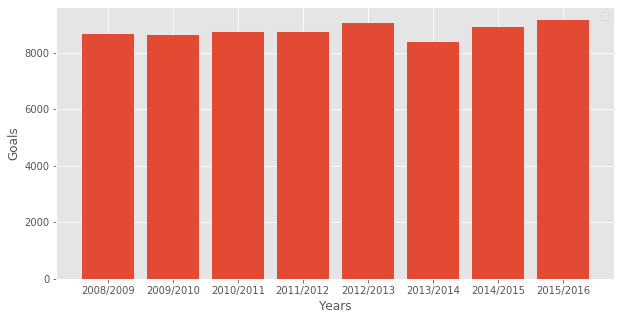

4    9039
Name: total_goal, dtype: int64

In [7]:
# Show total goals per season for all european competitions
dataset_dictionary["Match"] ["total_goal"] = dataset_dictionary["Match"]["home_team_goal"]+dataset_dictionary["Match"]["away_team_goal"]
data = dataset_dictionary["Match"].groupby("season").agg({"total_goal":"sum"}).reset_index()
invoke_plotter(data=data["season"],y=data["total_goal"],figsize=(10,5),xlabel="years",ylabel="goals",type="bar")
data[data["season"]=="2012/2013"]["total_goal"]

### 2.3  Use SQL to query the match table joining league and teams. Use the query to seperate the datasets, based on league and season 2014/2015
A two new features were added overall_player_away_rating (Player rating for away team) and overall_player_home_rating (Player rating for ho,e team) . The rating is the average of all player's rating. Players that don't have value for overal rating were imputed using average. Please note that player one is always the goal keeper. Although all teams have different schema we used column mean to impute the missing values.

In [8]:
# Filter out the league of interest using SQL query for season 2014/2015
select_query_function = lambda league,season :f"""SELECT
   Match.date,
   Match.home_team_api_id,
   season,
   home_team_goal,
   away_team_goal,
   B365H,
   B365D,
   B365A,
   home_player_1,
   home_player_2,
   home_player_3,
   home_player_4,
   home_player_5,
   home_player_6,
   home_player_7,
   home_player_8,
   home_player_9,
   home_player_10,
   home_player_11,
   away_player_1,
   away_player_2,
   away_player_3,
   away_player_4,
   away_player_5,
   away_player_6,
   away_player_7,
   away_player_8,
   away_player_9,
   away_player_10,
   away_player_11,
   Country.name AS country_name,
   League.name AS league_name,
   HT.team_long_name AS home_team,
   AT.team_long_name AS away_team 
FROM
   Match 
   JOIN
      Country 
      on Country.id = Match.country_id 
   JOIN
      League 
      on League.id = Match.league_id 
   LEFT JOIN
      Team AS HT 
      on HT.team_api_id = Match.home_team_api_id 
   LEFT JOIN
      Team AS AT 
      on AT.team_api_id = Match.away_team_api_id 
WHERE
   League.name = {league} 
   and season = {season} 
ORDER by
   date;"""
england_premier_league_matches = pd.read_sql(select_query_function("'England Premier League'","'2014/2015'") ,get_connection())
france_league_matches = pd.read_sql(select_query_function("'France Ligue 1'","'2014/2015'") ,get_connection())
germany_bundes_league_matches = pd.read_sql(select_query_function("'Germany 1. Bundesliga'","'2014/2015'") ,get_connection())
italy_serie_a_league_matches = pd.read_sql(select_query_function("'Italy Serie A'","'2014/2015'") ,get_connection())
spain_la_league_matches = pd.read_sql(select_query_function("'Spain LIGA BBVA'","'2014/2015'") ,get_connection())

spain_league_player_dataset = data_pipeline(dataset_dictionary,spain_la_league_matches)
england_league_player_dataset = data_pipeline(dataset_dictionary,england_premier_league_matches )
france_league_player_dataset = data_pipeline(dataset_dictionary,france_league_matches)
italy_serie_a_league_player_dataset = data_pipeline(dataset_dictionary,italy_serie_a_league_matches)
germany_bundes_league_player_dataset = data_pipeline(dataset_dictionary,germany_bundes_league_matches)

spain_la_league_matches_2015 = pd.read_sql(select_query_function("'Spain LIGA BBVA'","'2015/2016'") ,get_connection())


### 2.4 Summarize the competition home and away goals for season 2014/2015. We can conclude that in all competitions teams score more goals during their home games. La Liga has the biggest count of goals scored during home games season 2014/2015 with 584 goals and 425 away goals

home_team_goal  away_team_goal
league_name                                           
Germany 1. Bundesliga              486             357
France Ligue 1                     536             411
England Premier League             560             415
Italy Serie A                      568             450
Spain LIGA BBVA                    584             425


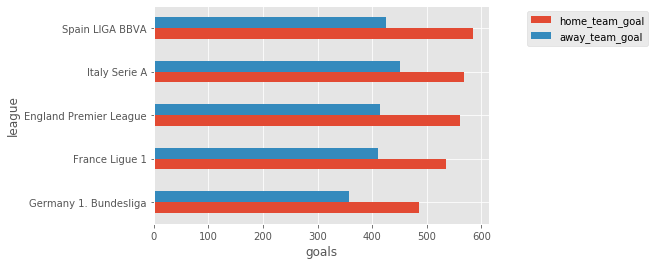

date  home_team_api_id     season  home_team_goal  \
0    2014-08-23 00:00:00              8302  2014/2015               1   
1    2014-08-23 00:00:00              9864  2014/2015               1   
2    2014-08-23 00:00:00              7878  2014/2015               2   
3    2014-08-23 00:00:00              9865  2014/2015               1   
4    2014-08-24 00:00:00              8581  2014/2015               0   
..                   ...               ...        ...             ...   
301  2015-05-23 00:00:00              9904  2014/2015               2   
302  2015-05-23 00:00:00              9810  2014/2015               2   
303  2015-05-23 00:00:00              9790  2014/2015               2   
304  2015-05-23 00:00:00              8722  2014/2015               2   
305  2015-05-23 00:00:00              8460  2014/2015               1   

     away_team_goal  B365H  B365D  B365A  home_player_1  home_player_2  ...  \
0                 1   2.05   3.50   3.50           63.0           61.0  ...   
1                 0   2.80   3.30   2.45           81.0           57.0  ...   
2                 1   1.95   3.20   4.20           61.0           63.0  ...   
3                 1   2.55   3.30   2.70           64.0           51.0  ...   
4                 2   3.40   3.40   2.10           66.0           65.0  ...   
..              ...    ...    ...    ...            ...            ...  ...   
301               1   1.95   3.60   3.80           61.0           60.0  ...   
302               1   4.50   4.33   1.67           52.0           60.0  ...   
303               0   2.40   3.60   2.80           78.0           75.0  ...   
304               2   3.80   3.80   1.91           55.0           66.0  ...   
305               2   3.40   3.80   2.05           53.0           58.0  ...   

     away_player_9  away_player_10  away_player_11  country_name  \
0             69.0            57.0            66.0         Spain   
1             61.0            71.0            75.0         Spain   
2             61.0            61.0            69.0         Spain   
3             79.0            62.0            67.1         Spain   
4             70.0            65.0            78.0         Spain   
..             ...             ...             ...           ...   
301           61.0            63.0            46.0       Germany   
302           67.0            63.0            76.0       Germany   
303           59.0            58.0            83.0       Germany   
304           62.0            67.0            60.0       Germany   
305           62.0            65.0            59.0       Germany   

               league_name            home_team                  away_team  \
0          Spain LIGA BBVA           Sevilla FC                Valencia CF   
1          Spain LIGA BBVA            Málaga CF    Athletic Club de Bilbao   
2          Spain LIGA BBVA           Granada CF  RC Deportivo de La Coruña   
3          Spain LIGA BBVA           UD Almería               RCD Espanyol   
4          Spain LIGA BBVA           Levante UD              Villarreal CF   
..                     ...                  ...                        ...   
301  Germany 1. Bundesliga          Hannover 96                SC Freiburg   
302  Germany 1. Bundesliga  Eintracht Frankfurt        Bayer 04 Leverkusen   
303  Germany 1. Bundesliga         Hamburger SV              FC Schalke 04   
304  Germany 1. Bundesliga           1. FC Köln              VfL Wolfsburg   
305  Germany 1. Bundesliga      SC Paderborn 07              VfB Stuttgart   

     overall_player_away_rating  overall_player_home_rating  goals  
0                     63.845455                   63.545455      2  
1                     68.845455                   65.000000      1  
2                     65.727273                   60.272727      3  
3                     65.081818                   62.000000      2  
4                     66.272727                   66.090909      2  
..                        

In [9]:
# Show goals ordered by home team goals descending
all_leagues_stacked = pd.concat([spain_league_player_dataset, england_league_player_dataset,france_league_player_dataset,italy_serie_a_league_player_dataset,germany_bundes_league_player_dataset], axis=0)
invoke_plotter(all_leagues_stacked,aggregate={"home_team_goal":"sum","away_team_goal":"sum"},xlabel="goals",ylabel="league",type="barh",group_by="league_name")
all_leagues_stacked

In [10]:
all_leagues_stacked.dtypes

date                           object
home_team_api_id                int64
season                         object
home_team_goal                  int64
away_team_goal                  int64
B365H                         float64
B365D                         float64
B365A                         float64
home_player_1                 float64
home_player_2                 float64
home_player_3                 float64
home_player_4                 float64
home_player_5                 float64
home_player_6                 float64
home_player_7                 float64
home_player_8                 float64
home_player_9                 float64
home_player_10                float64
home_player_11                float64
away_player_1                 float64
away_player_2                 float64
away_player_3                 float64
away_player_4                 float64
away_player_5                 float64
away_player_6                 float64
away_player_7                 float64
away_player_

### 2.5 On the other hand most goals scored in european competition during season 2014/2015 are in Italy Serie A - 1018 or nine more than La Liga

goals
league_name                  
Germany 1. Bundesliga     843
France Ligue 1            947
England Premier League    975
Spain LIGA BBVA          1009
Italy Serie A            1018


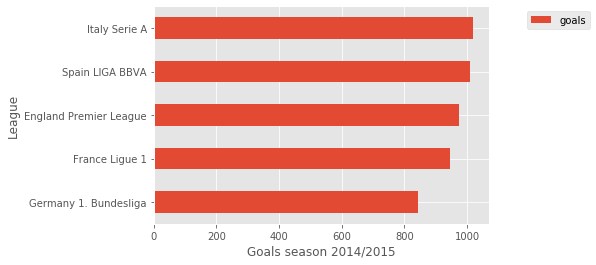

In [11]:
# Aggregate the goals for season 2014/2015 and order them descending by league
invoke_plotter(all_leagues_stacked,aggregate={"goals":"sum"},xlabel="Goals season 2014/2015",ylabel="League",type="barh",group_by="league_name")

### 2.6 Show the team with the most scored goals at home (Home team that scored most goals in domestic league)

home_team_goal
home_team                          
Manchester United                41
Valencia CF                      42
Atlético Madrid                  42
Manchester City                  44
Napoli                           44
Juventus                         45
FC Bayern Munich                 46
Paris Saint-Germain              52
FC Barcelona                     64
Real Madrid CF                   65


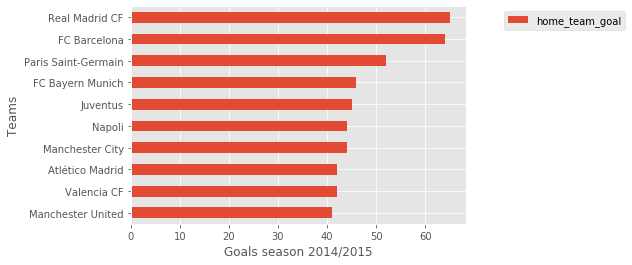

In [12]:
# Aggregate the results by team using home team as group by, top 10 teams with most goals scored in home matches
invoke_plotter(all_leagues_stacked,aggregate={"home_team_goal":"sum"},xlabel="Goals season 2014/2015",ylabel="Teams",type="barh",group_by="home_team",limit_to=10)

### 2.7 Show the team with the most scored goals as guest
Real Madrid and  FC Barcelona were the teams with most goals scored in both home and away matches for season 2014/2015.

away_team_goal
away_team                             
Paris Saint-Germain                 31
Olympique Lyonnais                  32
Sevilla FC                          33
VfL Wolfsburg                       34
FC Bayern Munich                    34
Olympique de Marseille              36
Chelsea                             37
Manchester City                     39
FC Barcelona                        46
Real Madrid CF                      53


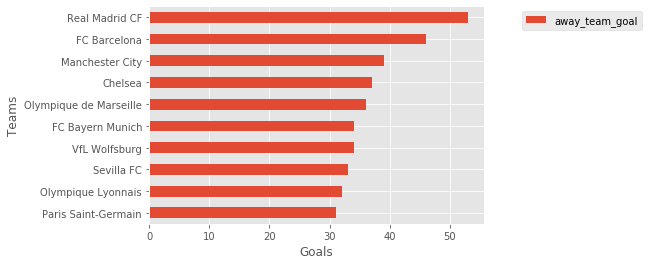

In [13]:
# Aggregate the results by team using home team as group by, top 10 teams with most goals scored in away matches
invoke_plotter(all_leagues_stacked,aggregate={"away_team_goal":"sum"},xlabel="Goals",ylabel="Teams",type="barh",group_by="away_team",limit_to=10)

### 2.8 Compare distributions of goals at home and as guest

<Figure size 360x360 with 0 Axes>

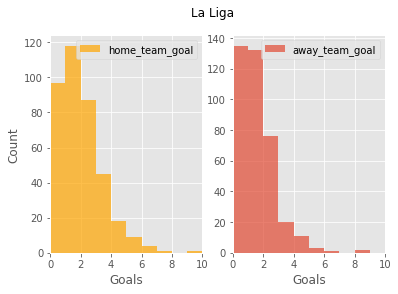

<Figure size 360x360 with 0 Axes>

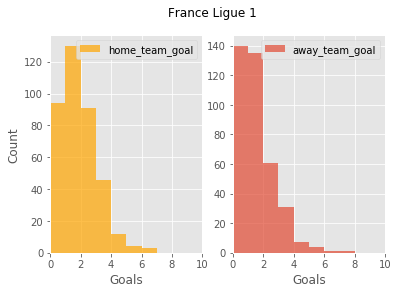

<Figure size 360x360 with 0 Axes>

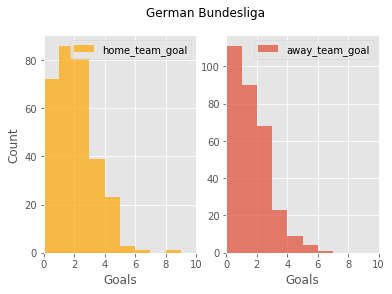

<Figure size 360x360 with 0 Axes>

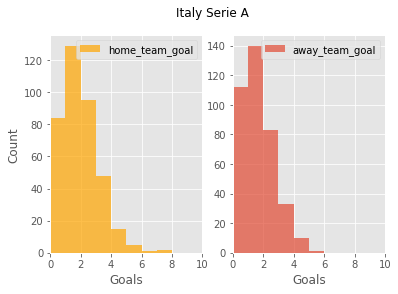

<Figure size 360x360 with 0 Axes>

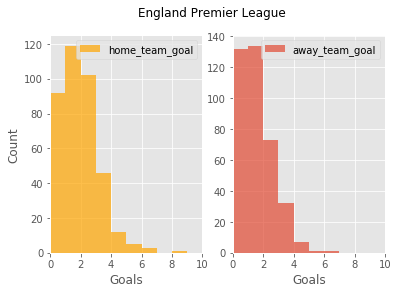

In [14]:
invoke_plotter(spain_la_league_matches,type='compare_distributions',columns_name=['home_team_goal','away_team_goal'],xlabel="goals",ylabel="count",title="la liga")
invoke_plotter(france_league_matches,type='compare_distributions',columns_name=['home_team_goal','away_team_goal'],xlabel="goals",ylabel="count",title="France Ligue 1")
invoke_plotter(germany_bundes_league_matches,type='compare_distributions',columns_name=['home_team_goal','away_team_goal'],xlabel="goals",ylabel="count",title="German Bundesliga")
invoke_plotter(italy_serie_a_league_matches,type='compare_distributions',columns_name=['home_team_goal','away_team_goal'],xlabel="goals",ylabel="count",title="italy serie a")
invoke_plotter(england_premier_league_matches,type='compare_distributions',columns_name=['home_team_goal','away_team_goal'],xlabel="goals",ylabel="count",title="england premier league")

### 2.9 Teams tend to score more goals at home than as guest

#### Null hyphothesis 
- The teams score same amount of goals during home and away games

#### Alternative hypothesis 
- The teams score different count of goals during home and away games

##### The Mann-Whitney U Test will be used to test if the distributions were equal, because the datasets are not normally distributed and are skewed. 
Steps to perform Mann-Whitney U Test:

1. Assign numeric ranks to all the observations (put the observations from both groups to one set), beginning with 1 for the smallest value. Where there are groups of tied values, assign a rank equal to the midpoint of unadjusted rankings. E.g., the ranks of (3, 5, 5, 5, 5, 8) are (1, 3.5, 3.5, 3.5, 3.5, 6) (the unadjusted rank would be (1, 2, 3, 4, 5, 6))
2. Now, add up the ranks for the observations which came from sample 1. The sum of ranks in sample 2 is now determinate, since the sum of all the ranks equals N(N + 1)/2 where N is the total number of observations.
3. Calculate U for the two samples:

$$ U_{1} = R_{1} - \frac{n_{1}*(n_{1}+1)}{2} $$ 
where n1 is the sample size for sample 1, and R1 is the sum of the ranks in sample 1.
$$ U_{2} = R_{2} - \frac{n_{2}*(n_{2}+1)}{2} $$ 

4. The smaller value of U1 and U2 is the one used when consulting significance tables. The result should be greater than the critical value from  the significance table which corresponds to 0.05

In python we can directly compare with the critical value of 0.05. If the value is greater than 0.05 we can't reject the $ H_{0} $
Following tests are also from interest:

##### We will use Kruskal–Wallis one-way analysis of variance to test for significance for more than two distributions, which uses following steps:

1. Rank all data from all groups together; i.e., rank the data from 1 to N ignoring group membership. Assign any tied values the average of the ranks they would have received had they not been tied.
2. Test statistics is given by

$$ H = (N-1) \frac{\sum_{i=1}^{g}n_{i}(\overline{r_{i}}- \overline{r})^2}{\sum_{i=1}^{g}\sum_{j=1}^{n_{i}}(r_{ij}-\overline{r})^2} $$

- $ n_{i} $ is the number of observations in group $ {\displaystyle i} $
- $ {\displaystyle r_{ij}} r_{ij} $ is the rank (among all observations) of observation $ {\displaystyle j} $ from group $ {\displaystyle i} $
- $ {\displaystyle N} $ is the total number of observations across all groups
- $ {\displaystyle {\bar {r}}_{i\cdot }={\frac {\sum _{j=1}^{n_{i}}{r_{ij}}}{n_{i}}}} \bar{r}_{i\cdot} = \frac{\sum_{j=1}^{n_i}{r_{ij}}}{n_i} $ is the average rank of all observations in group $ {\displaystyle i} $
- $ \bar{r} =\tfrac 12 (N+1) $ is the average of all the $ {\displaystyle r_{ij}} $.

3. If the data contain no ties the denominator of the expression for $ {\displaystyle H} $ is exactly $ {\displaystyle (N-1)N(N+1)/12} $ and $ {\displaystyle {\bar {r}}={\tfrac {N+1}{2}}} $. Thus 
        $$ H = \frac{12}{N(n+1)}\sum_{i=1}^{g}\frac{\overline{r_{i}}^2}{n_i} - 3(N+1) $$
            The last formula only contains the squares of the average ranks.

4. A correction for ties if using the short-cut formula described in the previous point can be made by dividing $ {\displaystyle H} $ by $ {\displaystyle 1-{\frac {\sum _{i=1}^{G}(t_{i}^{3}-t_{i})}{N^{3}-N}}} $, where G is the number of groupings of different tied ranks, and ti is the number of tied values within group i that are tied at a particular value. This correction usually makes little difference in the value of H unless there are a large number of ties.
5. Finally, the decision to reject or not the null hypothesis is made by comparing $ {\displaystyle H} $ to a critical value $ {\displaystyle H_{c}} $ obtained from a table or a software for a given significance or alpha level. If $ {\displaystyle H} $ is bigger than  $ {\displaystyle H_{c}} $ , the null hypothesis is rejected. If possible (no ties, sample not too big) one should compare $ {\displaystyle H} $ to the critical value obtained from the exact distribution of $ {\displaystyle H} $. Otherwise, the distribution of H can be approximated by a chi-squared distribution with g-1 degrees of freedom. If some $ {\displaystyle n_{i}} $ values are small (i.e., less than 5) the exact probability distribution of $ {\displaystyle H} $ can be quite different from this chi-squared distribution. If a table of the chi-squared probability distribution is available, the critical value of chi-squared, $  {\displaystyle \chi _{\alpha :g-1}^{2}} $, can be found by entering the table at g − 1 degrees of freedom and looking under the desired significance or alpha level.
6. If the statistic is not significant, then there is no evidence of stochastic dominance between the samples. However, if the test is significant then at least one sample stochastically dominates another sample. Therefore, a researcher might use sample contrasts between individual sample pairs, or post hoc tests using Dunn's test, which properly employs the same rankings as the Kruskal–Wallis test, and  properly employs the pooled variance implied by the null hypothesis of the Kruskal–Wallis test in order to determine which of the sample pairs are significantly different. When performing multiple sample contrasts or tests, the Type I error rate tends to become inflated, raising concerns about multiple comparisons.

In [15]:
compare_distributions(spain_la_league_matches,"home_team_goal","away_team_goal","country_name")
compare_distributions(france_league_matches,"home_team_goal","away_team_goal","country_name")
compare_distributions(germany_bundes_league_matches,"home_team_goal","away_team_goal","country_name")
compare_distributions(italy_serie_a_league_matches,"home_team_goal","away_team_goal","country_name")
compare_distributions(england_premier_league_matches,"home_team_goal","away_team_goal","country_name")
compare_distributions(spain_la_league_matches_2015,"home_team_goal","away_team_goal","country_name")

stat, p = kruskal(spain_la_league_matches['away_team_goal'], france_league_matches['away_team_goal'],germany_bundes_league_matches['away_team_goal'],italy_serie_a_league_matches['away_team_goal'],spain_la_league_matches['away_team_goal'],england_premier_league_matches["away_team_goal"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
if p > ALPHA:
	print('Same distributions for away goals for all selected countries (fail to reject H0)')
else:
	print('Different distributions for away goals for all selected countries (reject H0)')


stat, p = kruskal(spain_la_league_matches['home_team_goal'], france_league_matches['home_team_goal'],germany_bundes_league_matches['home_team_goal'],italy_serie_a_league_matches['home_team_goal'],spain_la_league_matches['home_team_goal'],england_premier_league_matches["home_team_goal"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
if p > ALPHA:
	print('Same distributions for home goals for all selected countries (fail to reject H0)')
else:
	print('Different distributions for home goals for all selected countries (reject H0)')

print ("Competition: ",italy_serie_a_league_matches["league_name"][0] ,"Home goals: ",italy_serie_a_league_matches['home_team_goal'].sum(),"Away goals: ",italy_serie_a_league_matches['away_team_goal'].sum())
print ("Competition: ",germany_bundes_league_matches["league_name"][0] ,"Home goals: ",germany_bundes_league_matches['home_team_goal'].sum(),"Away goals: ",germany_bundes_league_matches['away_team_goal'].sum())
print ("Competition: ",england_premier_league_matches["league_name"][0] ,"Home goals: ",england_premier_league_matches['home_team_goal'].sum(),"Away goals: ",england_premier_league_matches['away_team_goal'].sum())
print ("Competition: ",france_league_matches["league_name"][0] ,"Home goals: ",france_league_matches['home_team_goal'].sum(),"Away goals: ",france_league_matches['away_team_goal'].sum())
print ("Competition: ",spain_la_league_matches["league_name"][0] ,"Home goals: ",spain_la_league_matches['home_team_goal'].sum(),"Away goals: ",spain_la_league_matches['away_team_goal'].sum())

Statistics=59434.000, p=0.0000058
Different distribution (reject H0) for country: Spain
Statistics=59790.000, p=0.0000095
Different distribution (reject H0) for country: France
Statistics=37909.500, p=0.0000125
Different distribution (reject H0) for country: Germany
Statistics=62080.000, p=0.0003869
Different distribution (reject H0) for country: Italy
Statistics=59557.000, p=0.0000069
Different distribution (reject H0) for country: England
Statistics=57840.000, p=0.0000004
Different distribution (reject H0) for country: Spain
Statistics=5.117, p=0.402
Same distributions for away goals for all selected countries (fail to reject H0)
Statistics=2.953, p=0.707
Same distributions for home goals for all selected countries (fail to reject H0)
Competition:  Italy Serie A Home goals:  568 Away goals:  450
Competition:  Germany 1. Bundesliga Home goals:  486 Away goals:  357
Competition:  England Premier League Home goals:  560 Away goals:  415
Competition:  France Ligue 1 Home goals:  536 Away

### 2.10 Results
There is significant difference between the home and away goals. In general teams tend to score more goals, when they play at home stadium.
Team score different amount of goals depending on home/away matches. The home and away goal distributions reject the null hypothesis, that are both drought from same distribution.

## 3. Regression model for result forecasting based on Fifa player rating, BET365Lose, BET365Win, BET365Draw scores






In [16]:
columns = [league for league in all_leagues_stacked if 'home_player_' in league or 'away_player_' in league]
all_leagues_stacked["goal_difference"] = all_leagues_stacked["home_team_goal"] - all_leagues_stacked["away_team_goal"]
all_leagues_stacked['result_home'] = "D"

all_leagues_stacked['result_home'] = np.where(all_leagues_stacked['goal_difference'] > 0, "W", all_leagues_stacked['result_home'])
all_leagues_stacked['result_home'] = np.where(all_leagues_stacked['goal_difference'] < 0, "L", all_leagues_stacked['result_home'])


columns += ["country_name","league_name","goals","season","home_team_api_id","date","home_team_goal","away_team_goal","goal_difference"]
print(columns)

all_leagues_stacked.drop(columns,axis=1,inplace=True)



['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'country_name', 'league_name', 'goals', 'season', 'home_team_api_id', 'date', 'home_team_goal', 'away_team_goal', 'goal_difference']


### 3.1 Show teams using average home_team rating

In [17]:
all_leagues_stacked.groupby("home_team")["overall_player_home_rating"].describe().sort_values("mean",ascending=False)["mean"]

home_team
Manchester City     74.177033
Everton             70.827751
Real Madrid CF      70.821053
FC Barcelona        70.566986
FC Bayern Munich    70.556150
                      ...    
Burnley             58.566986
Crystal Palace      58.377033
AS Saint-Étienne    58.095694
FC Lorient          57.830144
SC Paderborn 07     57.529412
Name: mean, Length: 98, dtype: float64

### 3.2 Show teams using average away_team rating

In [18]:
all_leagues_stacked.groupby("away_team")["overall_player_away_rating"].describe().sort_values("mean",ascending=False)["mean"]

away_team
Manchester City     74.406699
Everton             71.033493
Real Madrid CF      71.013397
Milan               71.012919
FC Barcelona        70.143541
                      ...    
Crystal Palace      58.646411
Burnley             58.534928
AS Saint-Étienne    58.519617
FC Lorient          57.946411
SC Paderborn 07     57.534759
Name: mean, Length: 98, dtype: float64

In [19]:
all_leagues_stacked.columns
all_leagues_stacked.isnull().sum()

B365H                         0
B365D                         0
B365A                         0
home_team                     0
away_team                     0
overall_player_away_rating    0
overall_player_home_rating    0
result_home                   0
dtype: int64

### 3.3 Features explained, notmalization and label encoding
- B365H - win coefficient for the home team Bet 365
- B365D - draw coefficient Bet 365
- B365A - win for the away team Bet 365
- overall_player_home_rating - mean of the overall fifa rating of all player for the home team
- overall_player_away_rating - mean of the overall fifa rating of all player for the home team

- result_home - label D,W,L

Min Max Scaler is used to normalize the different scales of the features:

$$ x'={\frac {x-{\text{min}}(x)}{{\text{max}}(x)-{\text{min}}(x)}} $$

x' - the normalized feature
x  - the value to normalize

The Label is multiclass classification, because label that has more classes than a binary classifier or exactly three - win, loss and draw. LabelEncoder was used to encode the three classes. Label encoder uses ordinal encoder to transform the classes. This means that class win will be labeled as 2, class loss as 1 and draw will be 0.


### 3.4 Model creation using Logistic regression. Model metrics.  

Logistic regression is defined as:    
    
$$ \sigma (t)={\frac {e^{t}}{e^{t}+1}}={\frac {1}{1+e^{-t}}} $$
     
And in its general form:

$$ {\displaystyle p(x)=\sigma (t)={\frac {1}{1+e^{-(\beta _{0}+\beta _{1}x)}}}} $$

Model metrics

$$ Accuracy = \frac{(TP+TN)}{(TP+TN+FP+FN)} $$

Accuracy of Logistic Regression model using training data is: 53.90410958904109
Accuracy of Logistic Regression model  using test data is: 47.12328767123288


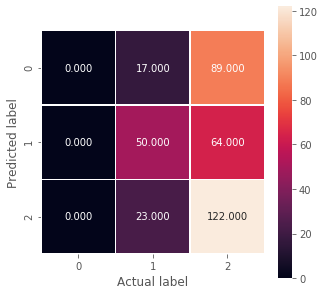

array([1, 2, 0])

In [20]:

x = all_leagues_stacked[["B365H",	"B365D",	"B365A","overall_player_home_rating" ,"overall_player_away_rating"]]
all_leagues_stacked[["B365H",	"B365D",	"B365A","overall_player_home_rating" ,"overall_player_away_rating","result_home"]].to_csv('out.csv', index=False)
y = all_leagues_stacked[["result_home"]]
label_encoder = LabelEncoder()
y = label_encoder.fit(y).transform(y)


min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
x_scaled = min_max_scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
clf = LogisticRegression( solver='newton-cg').fit(X_train, y_train)
clf.score(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("Accuracy of Logistic Regression model using training data is:",
metrics.accuracy_score(y_train, y_pred_train)*100)
print("Accuracy of Logistic Regression model  using test data is:",
metrics.accuracy_score(y_test, y_pred)*100)
cm = confusion_matrix(y_test, y_pred)

invoke_plotter(cm,type="heatmap",xlabel="Predicted label",ylabel="Actual label")

label_encoder.transform(["L","W","D"])

# clf1 = LogisticRegression(solver='saga',random_state=1)
# clf2 = RandomForestClassifier(n_estimators=50, random_state=0)
# clf3 = GaussianNB()
# eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],voting='hard')
# for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
#     scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

#### 3.4.1 Distribution of the label


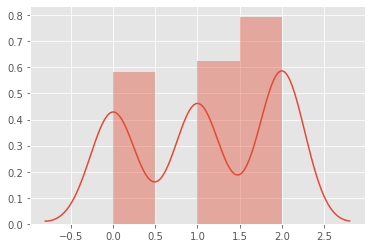

In [21]:
sns.distplot(y_test)
plt.show()

### 3.5 Results
The model has approximately 54 % accuracy. It has limited prediction capabilities. We can conclud that logisti regression based on BET365 coefficients and fifa game player rating would not perform well to predic game outcomes.

## 4. Exploratory data analysis for players. Does BMI or weight correlates with fifa player overall rating?

- calculate the bmi. The players weight is in pounds and height in cm
- calculate the correlation between BMI and player fifa overall rating
- show the distribution for all players

No handles with labels found to put in legend.
Correlation between bmi and player's fifa overall rating:  0.08542967363906809


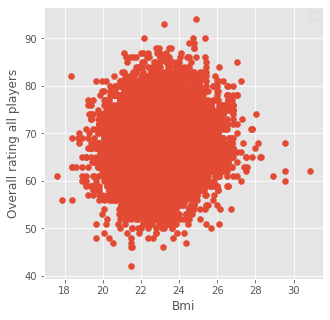

No handles with labels found to put in legend.
Correlation between bmi and player's fifa overall rating for top 100 players:  0.01700837101193358


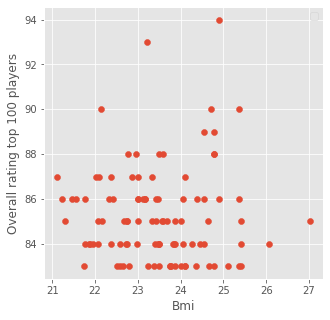

No handles with labels found to put in legend.


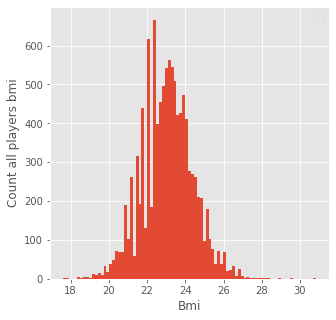

No handles with labels found to put in legend.


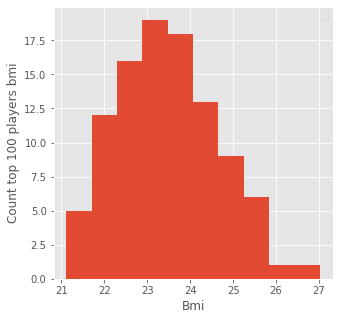

In [22]:
players_with_attributes = pd.merge(dataset_dictionary["Player"], dataset_dictionary["Player_Attributes"], on='player_api_id')
players_with_attributes=players_with_attributes.sort_values('date').drop_duplicates('player_name',keep='last')
bmi_column = players_with_attributes.loc[: , "height":"weight"]

players_with_attributes['bmi'] = players_with_attributes["weight"]/(2.205*players_with_attributes["height"]*players_with_attributes["height"])*10000
players_with_attributes['bmi']
players_with_attributes[["bmi","overall_rating"]].sort_values('overall_rating')
print("Correlation between bmi and player's fifa overall rating: ",players_with_attributes["bmi"].corr(players_with_attributes["overall_rating"]))

invoke_plotter(data=players_with_attributes["bmi"],y=players_with_attributes["overall_rating"],xlabel="bmi",ylabel="overall rating all players",type="scatter")
players_with_attributes = players_with_attributes.sort_values('overall_rating',ascending=False)
top_hundred_players_highest_overall_rating = players_with_attributes[players_with_attributes.overall_rating>80].head(100)[["overall_rating","player_name","bmi","weight","height","sprint_speed"]]
print("Correlation between bmi and player's fifa overall rating for top 100 players: ",top_hundred_players_highest_overall_rating["bmi"].corr(top_hundred_players_highest_overall_rating["overall_rating"]))

invoke_plotter(data=top_hundred_players_highest_overall_rating["bmi"],y=top_hundred_players_highest_overall_rating["overall_rating"],xlabel="bmi",ylabel="overall rating top 100 players",type="scatter")

invoke_plotter(data=players_with_attributes["bmi"],xlabel="bmi",ylabel="count all players bmi",type='hist')
invoke_plotter(data=top_hundred_players_highest_overall_rating["bmi"],xlabel="bmi",ylabel="count top 100 players bmi",type='hist')

### 4.1 Results for correlation bmi and overall player rating
There is no correlation between bmi and player fifa performance. The BMI of the football players is almost normally distrubuted.

### 4.2 Find the top performing player. Describe average BMI,weight,height, and average rating for top 100 players with highest overall rating

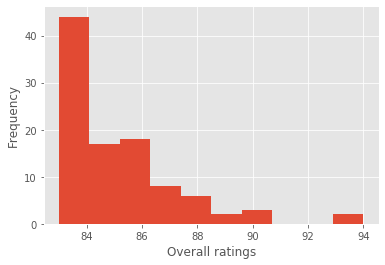

Top hundred player mean rating for season 2014/2015 is :  85.27
Top hundred player mean BMI for season 2014/2015 is :  23.45
Top hundred player mean weight for season 2014/2015 is :  78.46
Top hundred player mean height for season 2014/2015 is :  182.73


overall_rating        player_name        bmi  weight  height  \
102482            94.0       Lionel Messi  24.898403     159  170.18   
33330             93.0  Cristiano Ronaldo  23.216188     176  185.42   
109033            90.0       Manuel Neuer  24.705453     203  193.04   
131464            90.0             Neymar  22.147109     150  175.26   
105983            90.0        Luis Suarez  25.357159     187  182.88   
...                ...                ...        ...     ...     ...   
132805            83.0     Nicolas Gaitan  22.803285     150  172.72   
44731             83.0      Dimitri Payet  25.100057     170  175.26   
46353             83.0      Douglas Costa  21.739131     143  172.72   
101108            83.0   Leonardo Bonucci  23.744064     190  190.50   
16184             83.0         Arda Turan  24.101117     168  177.80   

        sprint_speed  
102482          90.0  
33330           93.0  
109033          61.0  
131464          90.0  
105983          78.0  
...              ...  
132805          82.0  
44731           75.0  
46353           87.0  
101108          75.0  
16184           70.0  

[100 rows x 6 columns]

In [23]:
ax   =top_hundred_players_highest_overall_rating["overall_rating"].hist()
ax.set_xlabel("Overall ratings")
ax.set_ylabel("Frequency")
plt.show()
print("Top hundred player mean rating for season 2014/2015 is : ",top_hundred_players_highest_overall_rating.overall_rating.mean())
print("Top hundred player mean BMI for season 2014/2015 is : ",np.round(top_hundred_players_highest_overall_rating.bmi.mean(),2))
print("Top hundred player mean weight for season 2014/2015 is : ",np.round(top_hundred_players_highest_overall_rating.weight.mean()/2.205,2))
print("Top hundred player mean height for season 2014/2015 is : ",np.round(top_hundred_players_highest_overall_rating.height.mean(),2))
top_hundred_players_highest_overall_rating

### 4.3 Find a correlation between player weight and fifa sprint speed

No handles with labels found to put in legend.
-0.43398395428228986


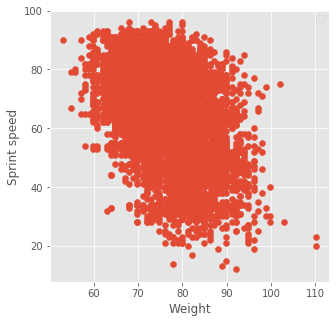

In [24]:
players_with_attributes = players_with_attributes.dropna()
print(players_with_attributes["weight"].corr(players_with_attributes["sprint_speed"]))
invoke_plotter(type="scatter",data=players_with_attributes["weight"]/2.205,y=players_with_attributes["sprint_speed"],xlabel="weight",ylabel="sprint speed")
players_with_attributes["weight"] = players_with_attributes["weight"]/2.205

### 4.4 Results for correlation bmi and sprint speed
There is a low negative correlation between weight and sprint speed. The sprint speed decreases when the weight increases

No handles with labels found to put in legend.


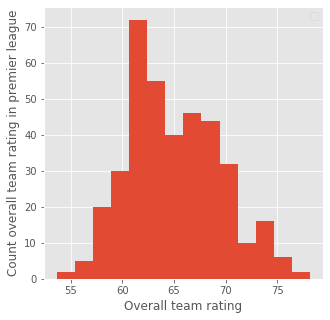

No handles with labels found to put in legend.


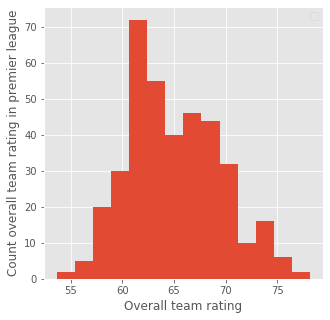

In [25]:
# Show overall team rating based on player away/home rating
england_league_player_dataset[ england_league_player_dataset["home_team"].str.contains("Manches")]
invoke_plotter(england_league_player_dataset['overall_player_away_rating'],xlabel=str.capitalize("Overall team rating"),ylabel=str.capitalize("Count overall team rating in premier league"),type='hist')
invoke_plotter(england_league_player_dataset['overall_player_away_rating'],xlabel=str.capitalize("Overall team rating"),ylabel=str.capitalize("Count overall team rating in premier league"),type='hist')

### 4.5 Find top 10 players, considered overweight with BMI above 25 and fifa overall rating above 80.

In [26]:

players_with_attributes[(players_with_attributes.bmi>25)&(players_with_attributes.overall_rating>80)].sort_values("overall_rating",ascending=False).head(10)

id_x  player_api_id       player_name  player_fifa_api_id_x  \
105983   6377          40636       Luis Suarez                176580   
118874   7137          36388      Mats Hummels                178603   
181668  10923          36615        Yaya Toure                 20289   
178940  10749          30829      Wayne Rooney                 54050   
71227    4283          20276              Hulk                189362   
84848    5120          30627        John Terry                 13732   
166130   9970          41097  Stephane Ruffier                167628   
121935   7300          46875     Mehdi Benatia                177509   
44731    2671          25496     Dimitri Payet                177388   
25468    1530          30661      Carles Puyol                 13038   

                   birthday  height     weight    id_y  player_fifa_api_id_y  \
105983  1987-01-24 00:00:00  182.88  84.807256  105984                176580   
118874  1988-12-16 00:00:00  190.50  92.063492  118875                178603   
181668  1983-05-13 00:00:00  187.96  89.795918  181669                 20289   
178940  1985-10-24 00:00:00  175.26  82.993197  178941                 54050   
71227   1986-07-25 00:00:00  180.34  84.807256   71228                189362   
84848   1980-12-07 00:00:00  187.96  89.795918   84830                 13732   
166130  1986-09-27 00:00:00  187.96  89.795918  166131                167628   
121935  1987-04-17 00:00:00  190.50  92.063492  121936                177509   
44731   1987-03-29 00:00:00  175.26  77.097506   44732                177388   
25468   1978-04-13 00:00:00  177.80  79.818594   25469                 13038   

                       date  ...  penalties  marking standing_tackle  \
105983  2015-10-16 00:00:00  ...       85.0     30.0            45.0   
118874  2016-01-14 00:00:00  ...       68.0     86.0            87.0   
181668  2016-03-10 00:00:00  ...       85.0     63.0            78.0   
178940  2016-03-03 00:00:00  ...       81.0     29.0            54.0   
71227   2016-05-05 00:00:00  ...       78.0     33.0            41.0   
84848   2016-03-10 00:00:00  ...       52.0     87.0            87.0   
166130  2016-01-14 00:00:00  ...       25.0     11.0            12.0   
121935  2016-03-24 00:00:00  ...       41.0     87.0            87.0   
44731   2016-04-14 00:00:00  ...       76.0     29.0            48.0   
25468   2014-03-28 00:00:00  ...       58.0     87.0            85.0   

       sliding_tackle gk_diving  gk_handling  gk_kicking  gk_positioning  \
105983           38.0      27.0         25.0        31.0            33.0   
118874           86.0      15.0          6.0        10.0             5.0   
181668           75.0      13.0         14.0         6.0            12.0   
178940           37.0      10.0         11.0        13.0             8.0   
71227            28.0       6.0         10.0         7.0            11.0   
84848            84.0      14.0          5.0         6.0            15.0   
166130           11.0      83.0         81.0        77.0            83.0   
121935           86.0       7.0          4.0         8.0             7.0   
44731            45.0      11.0         15.0         9.0            14.0   
25468            82.0      13.0          8.0        14.0            10.0   

        gk_reflexes        bmi  
105983         37.0  25.357159  
118874          6.0  25.368657  
181668          8.0  25.417084  
178940          7.0  27.019473  
71227          12.0  26.076475  
84848           8.0  25.417084  
166130         86.0  25.417084  
121935         11.0  25.368657  
44731          12.0  25.100057  
25468           9.0  25.248789  

[10 rows x 49 columns]

### 4.6 Show the bmi,weight, height and overall rating distributions

<function matplotlib.pyplot.show(*args, **kw)>

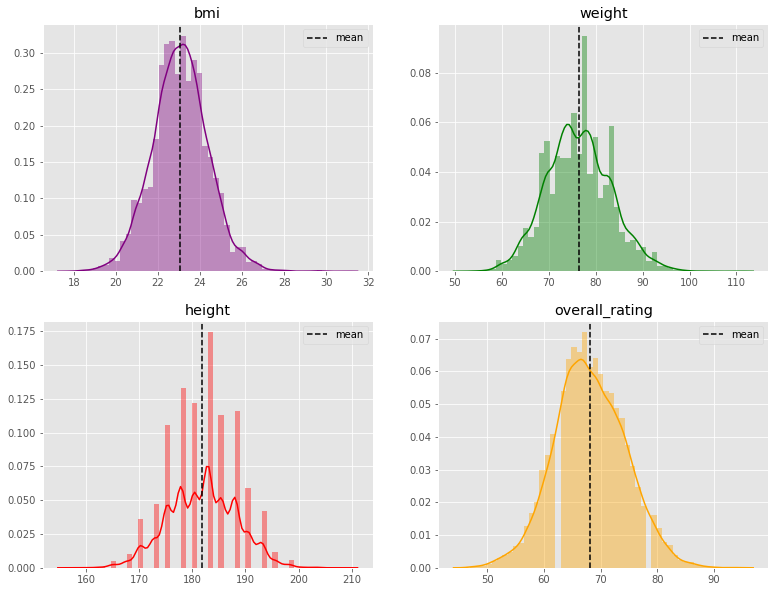

In [27]:
cols  = ["bmi","weight","height","overall_rating"]
length = len(cols)
c = ["purple","g","r","orange"]
plt.figure(figsize=(13,10))

for i,j,k in itertools.zip_longest(cols,range(length),c):
    plt.subplot(2,2,(j+1))
    sns.distplot(players_with_attributes[i],color=k)
    plt.axvline(players_with_attributes[i].mean(),color = "k",linestyle = "dashed",label="mean")
    plt.legend(loc="best")
    plt.title(i)
    plt.xlabel("")
plt.show

## References
1. Database source: https://www.kaggle.com/hugomathien/soccer 
2. Dima Rudov (14.05.2018). Data Analysis using SQL, source: https://www.kaggle.com/dimarudov/data-analysis-using-sql
3. Pavan Raj (04.09.2018). EUROPEAN FOOTBALL DATA ANALYSIS, source: https://www.kaggle.com/pavanraj159/european-football-data-analysis
4. Yo Yo CM (2016). How predict the outcome of 48% matches, source: https://www.kaggle.com/yoyocm/how-predict-the-outcome-of-48-matches
5. PDF - https://en.wikipedia.org/wiki/Probability_density_function
6. Histogram - https://en.wikipedia.org/wiki/Histogram
7. Logistic regression - https://machinelearningmastery.com/logistic-regression-for-machine-learning/
8. Logistic regression - https://en.wikipedia.org/wiki/Logistic_regression
9. Normalization - https://en.wikipedia.org/wiki/Normalization_(statistics)
10. Ordinal data - https://en.wikipedia.org/wiki/Ordinal_data
11. https://scikit-learn.org/stable/

